### Setup

In [1]:
# Initialize PyJNIus  

import jnius_config
jnius_config.add_options('-Xrs','-Xmx4096m')
jnius_config.set_classpath('.', '../../stl-decomp-4j/target/*')
import jnius
from jnius import autoclass

In [2]:
# Standard Imports and Extensions 
%matplotlib inline
%config InlineBackend.figure_format='retina' # Comment out if not on a mac

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16.0, 10.0) # (24.0, 15.0)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# In my python 2.7 environment, this is not set up by default - fix this.
if np.datetime64 not in mpl.units.registry:
    from pandas.tseries import converter as pdtc
    pdtc.register()

In [3]:
# Load the Java STL classes

SeasonalTrendLoess = autoclass('com.github.servicenow.ds.stats.stl.SeasonalTrendLoess')
StlBuilder = autoclass('com.github.servicenow.ds.stats.stl.SeasonalTrendLoess$Builder')

### Data

In [4]:
# Load the CO2 Data  

time = pd.date_range('3/1/1958 00:00:00', periods=708, freq='M')

df = pd.read_csv("../StlDemoRestServer/co2.csv")
df.index = time

del df['row']
del df['time_years']
df.columns = ["data"]

### Demo

Here's the Java code from the README:

```java
double[] values = getSomeMonthlyData(); // Monthly time-series data

SeasonalTrendLoess.Builder builder = new SeasonalTrendLoess.Builder();
SeasonalTrendLoess smoother = builder.
			setPeriodLength(12).    // Data has a period of 12
			setSeasonalWidth(35).   // Monthly data smoothed over 35 years
			setNonRobust().         // Not expecting outliers, so no robustness iterations
			buildSmoother(values);

SeasonalTrendLoess.Decomposition stl = smoother.decompose();
double[] seasonal = stl.getSeasonal();
double[] trend = stl.getTrend();
double[] residual = stl.getResidual();
```

Compare with the Python below:

In [5]:
# Build the smoother and perform the decomposition

values = df.data.values.tolist() # Unfortunately, PyJNIus doesn't seem to know about numpy
builder = StlBuilder()

smoother = builder. \
    setPeriodLength(12). \
    setSeasonalWidth(35). \
    setNonRobust(). \
    buildSmoother(values)

stl = smoother.decompose()
seasonal = stl.getSeasonal()
trend = stl.getTrend()
residual = stl.getResidual()


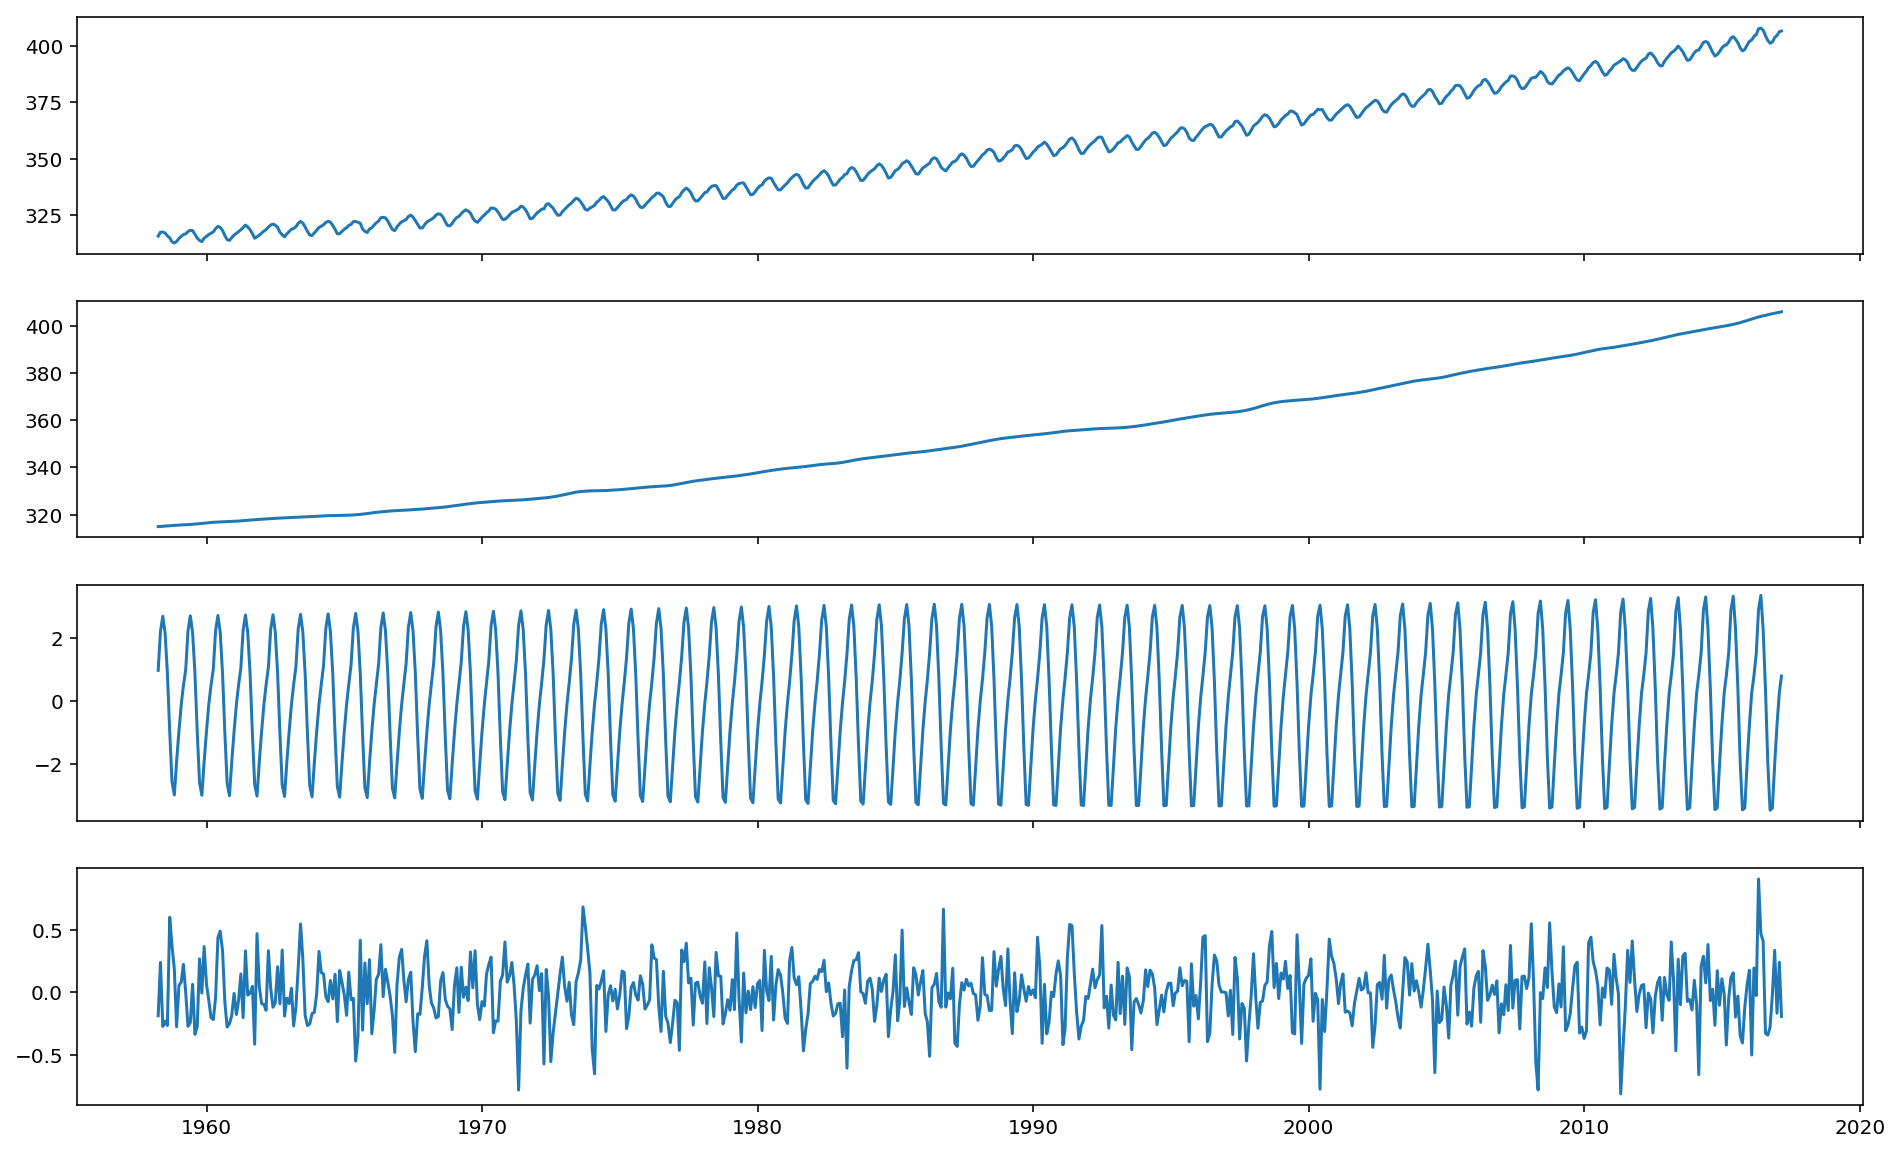

In [6]:
# Plot the decomposition

fig, axes = plt.subplots(4, sharex=True)

_ = axes[0].plot(df)
_ = axes[1].plot(df.index, trend)
_ = axes[2].plot(df.index, seasonal)
_ = axes[3].plot(df.index, residual)

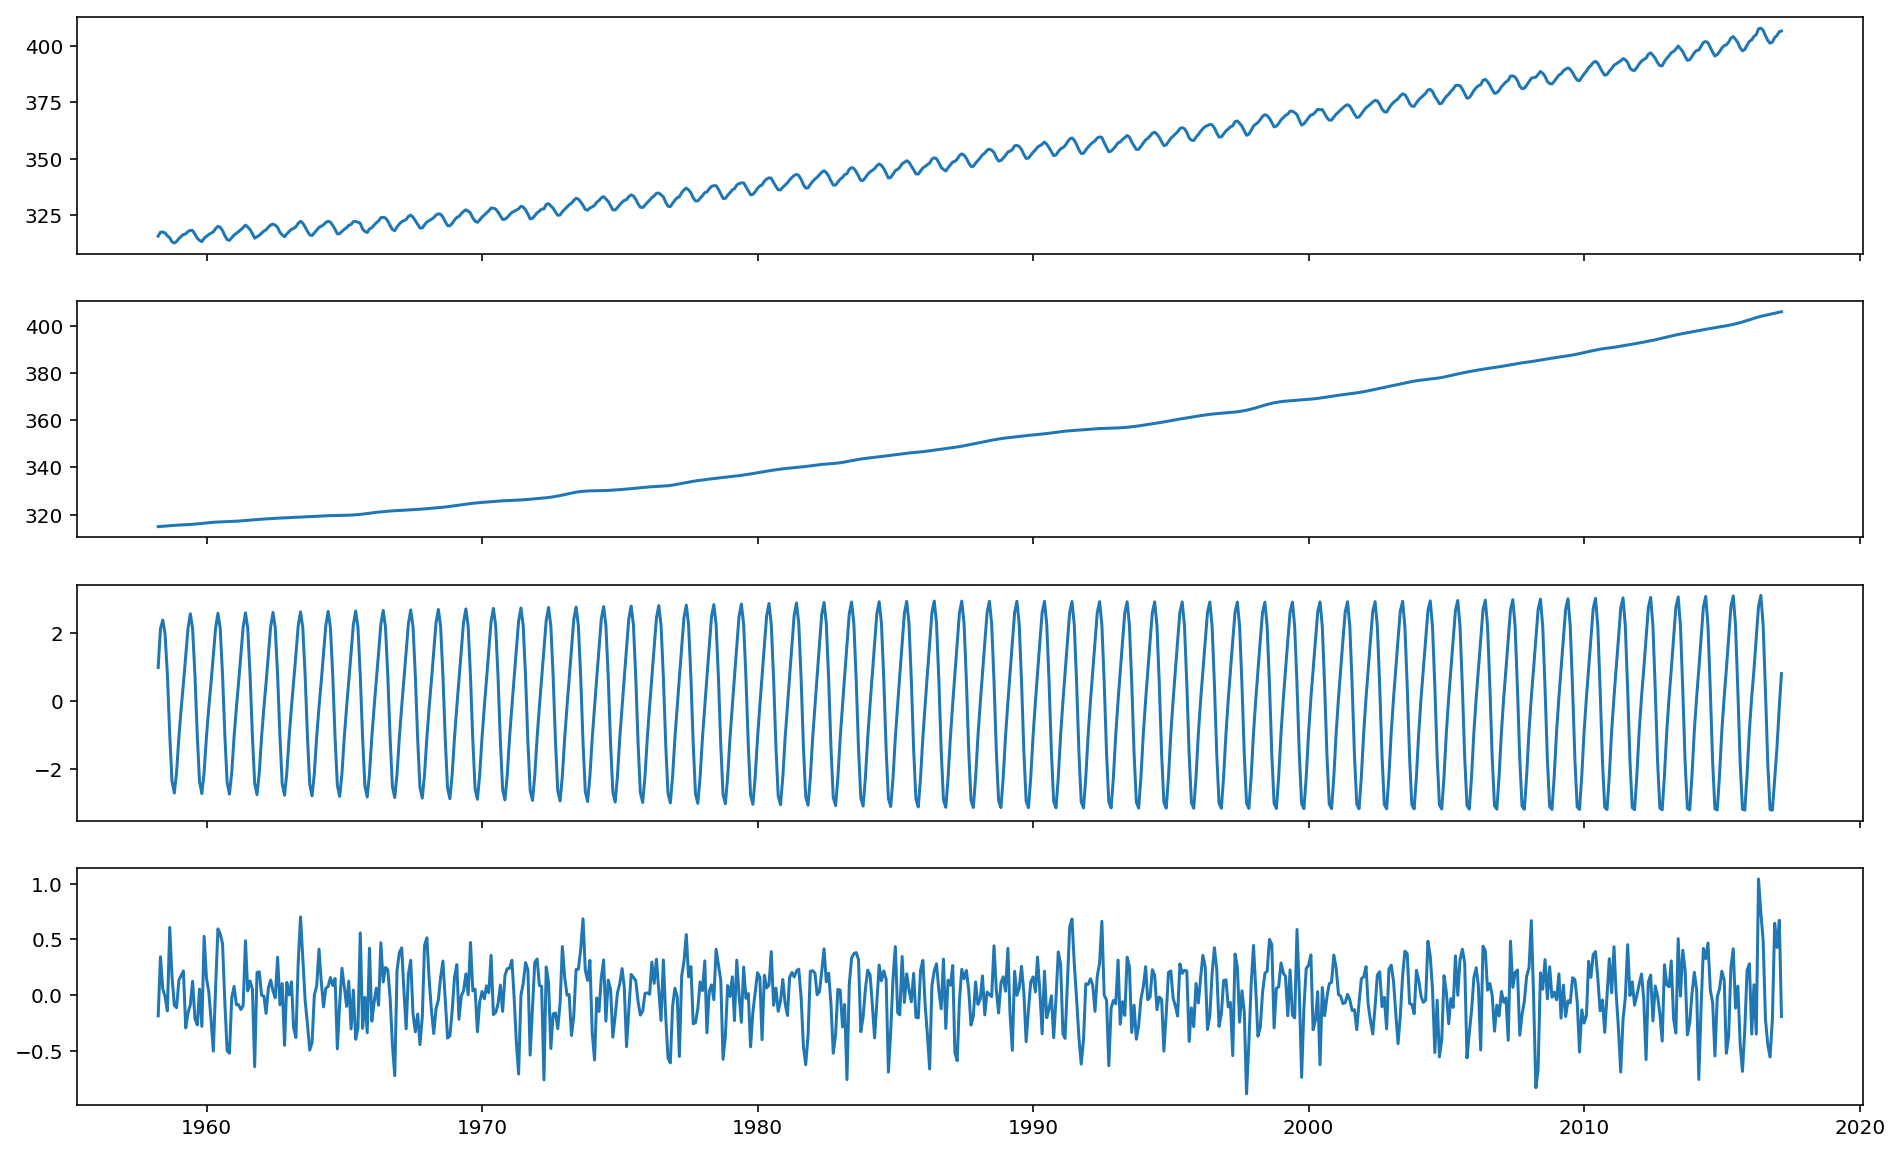

In [7]:
# Smooth the seasonal component and re-plot

stl.smoothSeasonal(9)

fig, axes = plt.subplots(4, sharex=True)

axes[0].plot(df.index, stl.getData())
axes[1].plot(df.index, stl.getTrend())
axes[2].plot(df.index, stl.getSeasonal())
_ = axes[3].plot(df.index, stl.getResidual())